In [48]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
from sklearn.metrics import recall_score, f1_score, precision_score, classification_report, make_scorer
import logging
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logger = logging.getLogger('lightgbm')

logger.setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

In [49]:
csv_relative_path = os.path.join("raw_data", "Pokemon.csv")
csv_file_path = os.path.abspath(csv_relative_path)
df_pokemon = pd.read_csv(csv_file_path)

In [50]:
df_pokemon.head()

#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False

1. Verificando schema da tabela e se há necessidade de alterar alguma tipagem ou preencher valores nulos

In [51]:
df_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Alguns pokemons tem evoluções "Mega", porém são tratados como um único Pokemon, embora os status Mega sejam mais fortes.
Vamos verificar se existe algum pokemon que não era lendário e passou a se tornar depois de virar Mega


In [52]:
def verify_mega_legendary(df_pokemon):
    """
    Retorna os Pokémon cuja forma normal NÃO é lendária,
    mas alguma de suas Mega Evoluções é marcada como lendária.

    Args:
        df_pokemon (pd.DataFrame): DataFrame contendo colunas 'Name' e 'Legendary'.

    Returns:
        pd.DataFrame: DataFrame com colunas:
                      ['Pokemon Base', 'É Lendário (Normal)', 'É Lendário (Alguma Mega)']
    """
    resultados = []

    # Obter os nomes base (sem Mega no nome)
    nomes_base = df_pokemon[~df_pokemon['Name'].str.contains("Mega")]['Name'].unique()

    for base in nomes_base:
        # Forma normal
        normal = df_pokemon[df_pokemon['Name'] == base]

        # Formas Mega com esse nome base
        megas = df_pokemon[df_pokemon['Name'].str.contains(f'^{base} Mega', regex=True)]

        if not normal.empty and not megas.empty:
            normal_is_legendary = normal['Legendary'].iloc[0]
            mega_is_legendary = megas['Legendary'].any()

            if not normal_is_legendary and mega_is_legendary:
                resultados.append({
                    'Pokemon Base': base,
                    'É Lendário (Normal)': normal_is_legendary,
                    'É Lendário (Alguma Mega)': mega_is_legendary
                })

    return pd.DataFrame(resultados)


In [53]:
results_legendary = verify_mega_legendary(df_pokemon)

In [54]:
print(results_legendary)

Empty DataFrame
Columns: []
Index: []


Vamos fazer um drop duplicates com base no ID, para retirar as evoluções mega ou qualquer outra variação.

In [55]:
df_pokemon = df_pokemon.drop_duplicates(subset=["#"])

In [56]:
df_pokemon.describe()

#  Total     HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  \
count 721.00 721.00 721.00  721.00   721.00   721.00   721.00 721.00   
mean  361.00 417.95  68.38   75.12    70.70    68.85    69.18  65.71   
std   208.28 109.66  25.85   29.07    29.19    28.90    26.90  27.28   
min     1.00 180.00   1.00    5.00     5.00    10.00    20.00   5.00   
25%   181.00 320.00  50.00   54.00    50.00    45.00    50.00  45.00   
50%   361.00 424.00  65.00   75.00    65.00    65.00    65.00  65.00   
75%   541.00 499.00  80.00   95.00    85.00    90.00    85.00  85.00   
max   721.00 720.00 255.00  165.00   230.00   154.00   230.00 160.00   

       Generation  
count      721.00  
mean         3.32  
std          1.67  
min          1.00  
25%          2.00  
50%          3.00  
75%          5.00  
max          6.00

1. Há valores nulos no "Type 2" dos pokemons. Alguns pokemon realmente só tem um Tipo, então podemos preencher com um None

In [57]:
df_pokemon['Type 2'].fillna('None', inplace=True)

In [58]:
df_pokemon.isnull().sum()

#             0
Name          0
Type 1        0
Type 2        0
Total         0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64

In [59]:
df_pokemon["Legendary"] = df_pokemon["Legendary"].astype(int)

In [60]:
df_pokemon.head()

#        Name Type 1  Type 2  Total  HP  Attack  Defense  Sp. Atk  Sp. Def  \
0  1   Bulbasaur  Grass  Poison    318  45      49       49       65       65   
1  2     Ivysaur  Grass  Poison    405  60      62       63       80       80   
2  3    Venusaur  Grass  Poison    525  80      82       83      100      100   
4  4  Charmander   Fire    None    309  39      52       43       60       50   
5  5  Charmeleon   Fire    None    405  58      64       58       80       65   

   Speed  Generation  Legendary  
0     45           1          0  
1     60           1          0  
2     80           1          0  
4     65           1          0  
5     80           1          0

In [61]:
df_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           721 non-null    int64 
 1   Name        721 non-null    object
 2   Type 1      721 non-null    object
 3   Type 2      721 non-null    object
 4   Total       721 non-null    int64 
 5   HP          721 non-null    int64 
 6   Attack      721 non-null    int64 
 7   Defense     721 non-null    int64 
 8   Sp. Atk     721 non-null    int64 
 9   Sp. Def     721 non-null    int64 
 10  Speed       721 non-null    int64 
 11  Generation  721 non-null    int64 
 12  Legendary   721 non-null    int64 
dtypes: int64(10), object(3)
memory usage: 78.9+ KB


In [62]:
df_pokemon = df_pokemon.rename(columns={'#': 'id'})

df_pokemon.columns = (
    df_pokemon.columns
    .str.lower()                    
    .str.replace(' ', '_', regex=False)  
    .str.replace('sp._', 'special_', regex=False) 
)

df_pokemon.columns

Index(['id', 'name', 'type_1', 'type_2', 'total', 'hp', 'attack', 'defense',
       'special_atk', 'special_def', 'speed', 'generation', 'legendary'],
      dtype='object')

In [63]:
df_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 0 to 799
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           721 non-null    int64 
 1   name         721 non-null    object
 2   type_1       721 non-null    object
 3   type_2       721 non-null    object
 4   total        721 non-null    int64 
 5   hp           721 non-null    int64 
 6   attack       721 non-null    int64 
 7   defense      721 non-null    int64 
 8   special_atk  721 non-null    int64 
 9   special_def  721 non-null    int64 
 10  speed        721 non-null    int64 
 11  generation   721 non-null    int64 
 12  legendary    721 non-null    int64 
dtypes: int64(10), object(3)
memory usage: 78.9+ KB


In [64]:
numerical_columns = ['total', 'hp', 'attack', 'defense', 'special_atk', 'special_def', 'speed']
categorical_columns = ['type_1', 'type_2', 'generation']
target = "legendary"

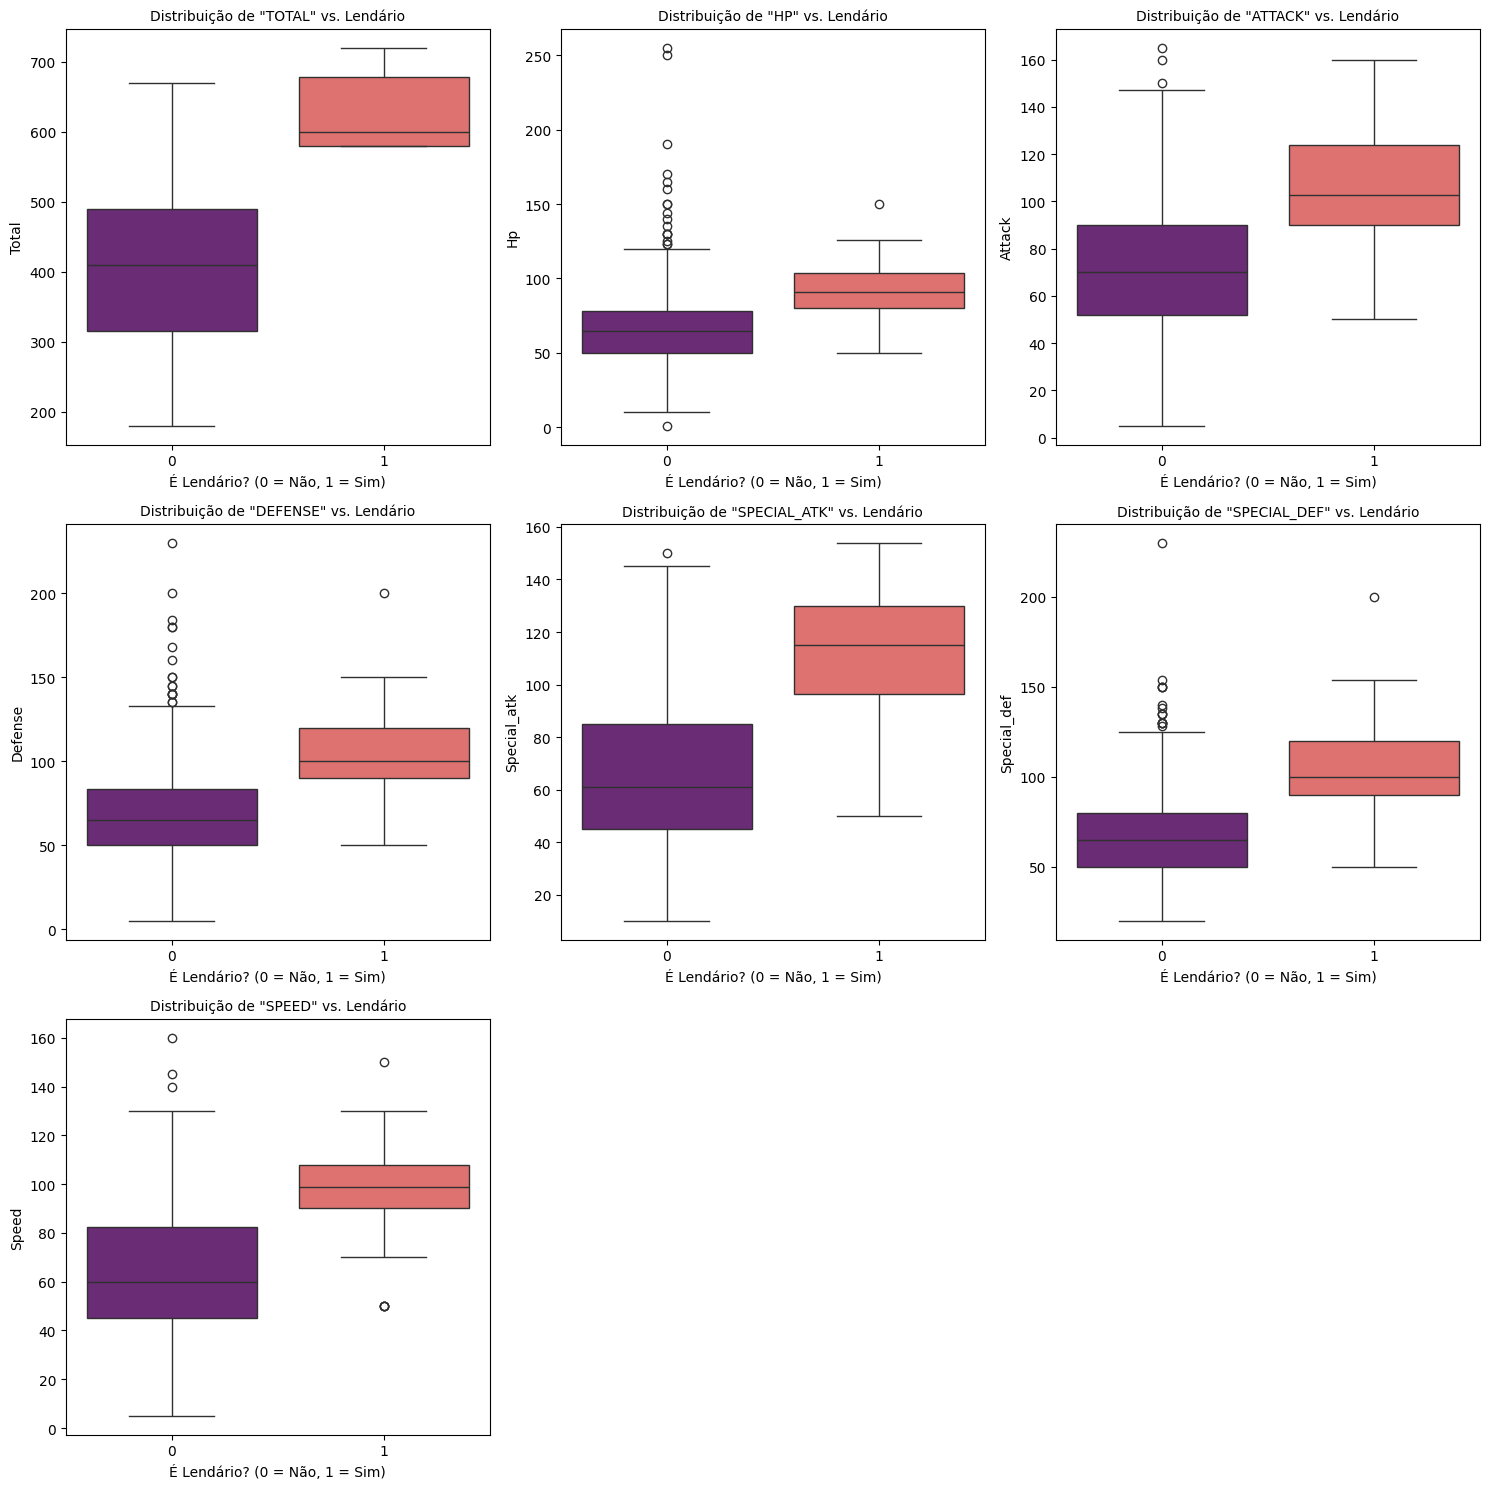

In [65]:
# Número de colunas para os gráficos (você pode ajustar conforme necessário)
ncols = 3
nrows = (len(numerical_columns) + ncols - 1) // ncols  # Calcular quantas linhas são necessárias

# Criação da figura e subgrids
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

# Ajustando a disposição para ficar mais legível
axes = axes.flatten()

# Plotando os gráficos de boxplot
for i, stat in enumerate(numerical_columns):
    sns.boxplot(x='legendary', y=stat, data=df_pokemon, palette='magma', ax=axes[i])
    axes[i].set_title(f'Distribuição de "{stat.upper()}" vs. Lendário', fontsize=10)
    axes[i].set_xlabel('É Lendário? (0 = Não, 1 = Sim)', fontsize=10)
    axes[i].set_ylabel(stat.capitalize(), fontsize=10)

# Remover qualquer subplot vazio, se existir
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Ajuste dos espaços entre os gráficos
plt.tight_layout()
plt.show()


##### Achados
1. A feature Total pode ser muito importante pro modelo, visto que os pokemons lendários são muito mais fortes do que a média dos pokemons.
2. As features individuais também estão sempre acima da média, com destaque para special Atack e Attack, que sao ligeiramente maiores para os lendários.

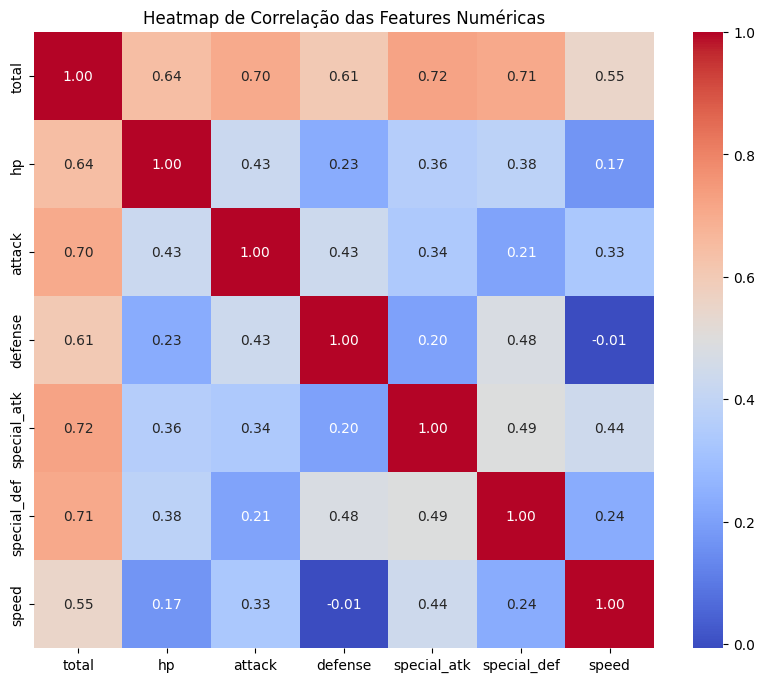

In [66]:
corr_matrix = df_pokemon[numerical_columns].corr()

# Plota o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação das Features Numéricas')
plt.show()

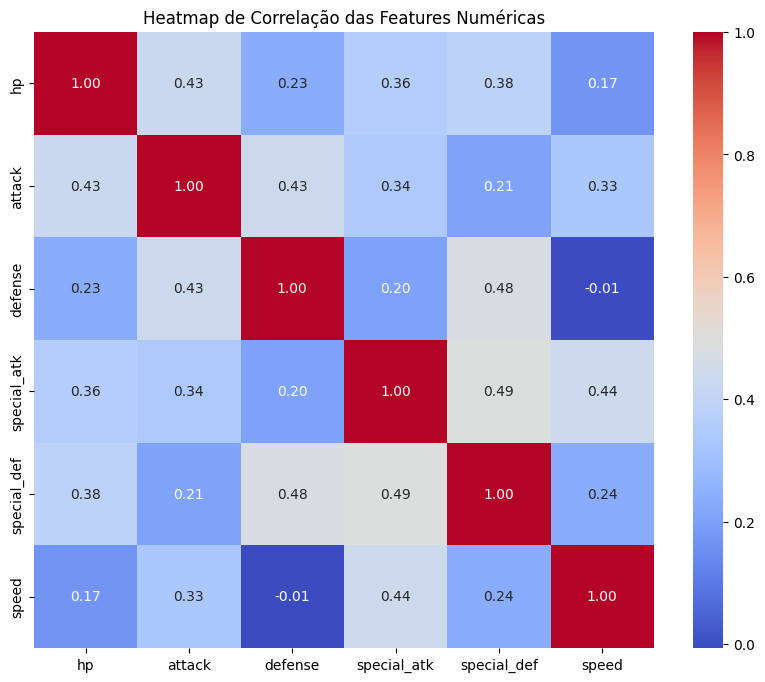

In [67]:
corr_matrix = df_pokemon[numerical_columns].drop(columns=['total']).corr()

# Plota o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação das Features Numéricas')
plt.show()

##### Achados

1. Correlação de total com as demais features era esperado, pois o total é o soma delas.
2. Correlação média entre defense e speed_def, provavelmente indicando alguns pokemons que são bem tanques
3. Correlação média entre special_def e special_atk, provavelmente indicando alguns pokemons que são bem equilibrados na velocidade 
4. Correlação média entre special_atk e speed, provavelmente indicando alguns pokemons que são atacantes velozes

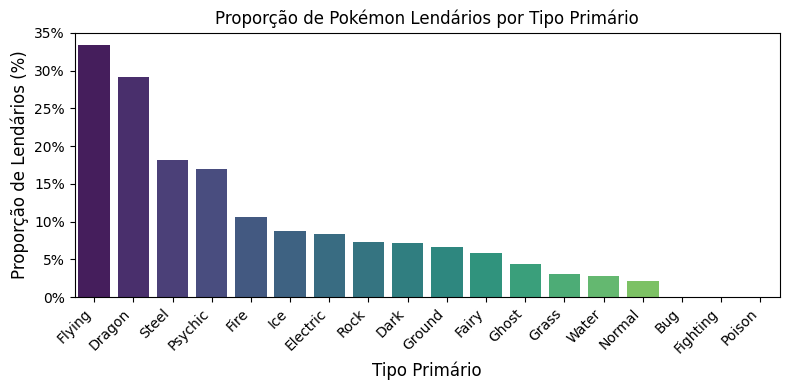

In [68]:
proporcao_lendarios_type_1 = (
    df_pokemon.groupby('type_1')['legendary']
    .mean()
    .sort_values(ascending=False)
)

# Criando o gráfico de barras
plt.figure(figsize=(8, 4))
sns.barplot(x=proporcao_lendarios_type_1.index, y=proporcao_lendarios_type_1.values, palette='viridis')
plt.title('Proporção de Pokémon Lendários por Tipo Primário', fontsize=12)
plt.xlabel('Tipo Primário', fontsize=12)
plt.ylabel('Proporção de Lendários (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.tight_layout()
plt.show()

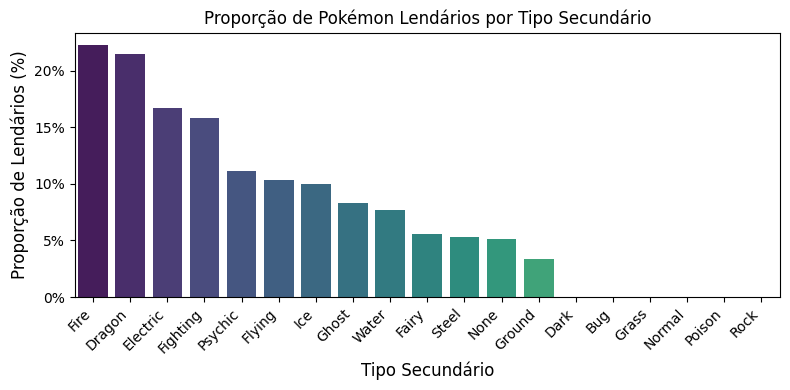

In [69]:
proporcao_lendarios_type_2 = (
    df_pokemon.groupby('type_2')['legendary']
    .mean()
    .sort_values(ascending=False)
)

# Criando o gráfico de barras
plt.figure(figsize=(8, 4))
sns.barplot(x=proporcao_lendarios_type_2.index, y=proporcao_lendarios_type_2.values, palette='viridis')
plt.title('Proporção de Pokémon Lendários por Tipo Secundário', fontsize=12)
plt.xlabel('Tipo Secundário', fontsize=12)
plt.ylabel('Proporção de Lendários (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.tight_layout()
plt.show()

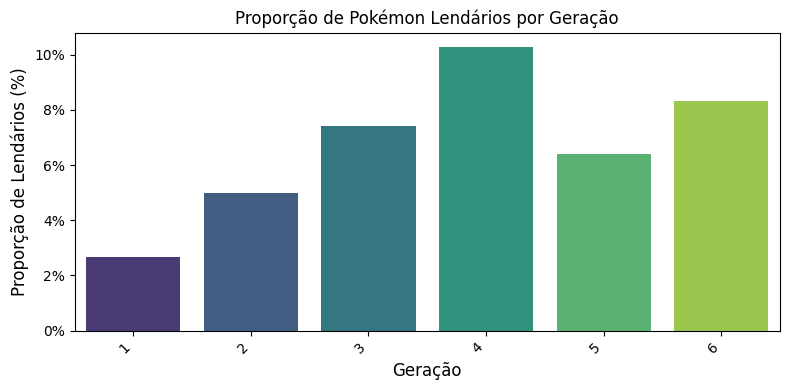

In [70]:
proporcao_lendarios_geracao = (
    df_pokemon.groupby('generation')['legendary']
    .mean()
    .sort_values(ascending=False)
)

# Criando o gráfico de barras
plt.figure(figsize=(8, 4))
sns.barplot(x=proporcao_lendarios_geracao.index, y=proporcao_lendarios_geracao.values, palette='viridis')
plt.title('Proporção de Pokémon Lendários por Geração', fontsize=12)
plt.xlabel('Geração', fontsize=12)
plt.ylabel('Proporção de Lendários (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.tight_layout()
plt.show()

##### Achados
1. Pokemons do tipo primário Flying, Dragon e Psychic tem maiores tendencias a serem lendários (destaque para Flying com 30% de média)
2. Pokemons do tipo primário Bug, Fighting e Poison não possuem lendários
3. Pokemons do tipo secundário Fire, Dragon e Ice tem maiores tendencias (>20%) a serem lendários
4. Pokemons do tipo secundário Bug, Grass, Normal, Poison e Rock não possuem lendários
5. Cerca de 5%~10% dos pokemons lendários não tem um tipo secundário
6. A partir da geração 3 temos mais lendários (8%>)


##### Criação de baseline

Pela distribuição de valores da coluna de Total, me parece que é uma das features mais fortes para predizer se um pokemon é lendário ou não.
Vamos criar um baseline baseado nela. Primeiro, vamos testar todos os valores, do mínimo até o máximo da feature de Total e calcular recall, precisão e f1 para todos eles. A partir disso, decidimos qual será o nosso modelo baseline. 

As métricas principais do meu modelo serão recall e f1-score. Com o recall, eu quero minimizar as vezes que o meu modelo deixe um lendário passar (modelo predizer que é um pokemon comum). Em conjunto vou olhar o f1-score e a precisão.


In [71]:
X_baseline = df_pokemon["total"]
y_baseline = df_pokemon[target]

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, test_size=0.25, random_state=42, stratify=y_baseline)

# Vamos testar todos os valores inteiros desde o mínimo até o máximo do 'total'
thresholds = np.arange(int(X_test_baseline.min()), int(X_test_baseline.max()), 1)

# 2. Listas para guardar os scores de cada teste
recall_scores = []
f1_scores = []
precision_scores = []

# 3. Loop para testar cada limite
for limite in thresholds:
    # Cria as previsões com base na regra atual
    y_pred_regra = (X_test_baseline > limite)
    
    # Calcula o recall e f1-score para a classe Lendário (pos_label=1)
    # zero_division=0 evita avisos se nenhuma previsão for feita
    recall = recall_score(y_test_baseline, y_pred_regra, pos_label=1, zero_division=0)
    f1 = f1_score(y_test_baseline, y_pred_regra, pos_label=1, zero_division=0)
    precision = precision_score(y_test_baseline, y_pred_regra, pos_label=1, zero_division=0)
    
    recall_scores.append(recall)
    f1_scores.append(f1)
    precision_scores.append(precision)

best_recall_index = np.argmax(recall_scores)
best_f1_index = np.argmax(f1_scores)
best_precision_index = np.argmax(precision_scores)

best_threshold_for_recall = thresholds[best_recall_index]
best_recall_score = recall_scores[best_recall_index]


best_threshold_for_f1 = thresholds[best_f1_index]
best_f1_score = f1_scores[best_f1_index]

best_threshold_for_precision = thresholds[best_precision_index]
best_precision_score = precision_scores[best_precision_index]

In [72]:
print(f"Melhor Limite para Recall: {best_threshold_for_recall} com Recall: {best_recall_score:.2%}")
print(f"Melhor Limite para Precision: {best_threshold_for_recall} com Precision: {best_precision_score:.2%}")
print(f"Melhor Limite para F1-Score: {best_threshold_for_f1} com F1-Score: {best_f1_score:.2%}")

Melhor Limite para Recall: 190 com Recall: 100.00%
Melhor Limite para Precision: 190 com Precision: 75.00%
Melhor Limite para F1-Score: 567 com F1-Score: 85.71%


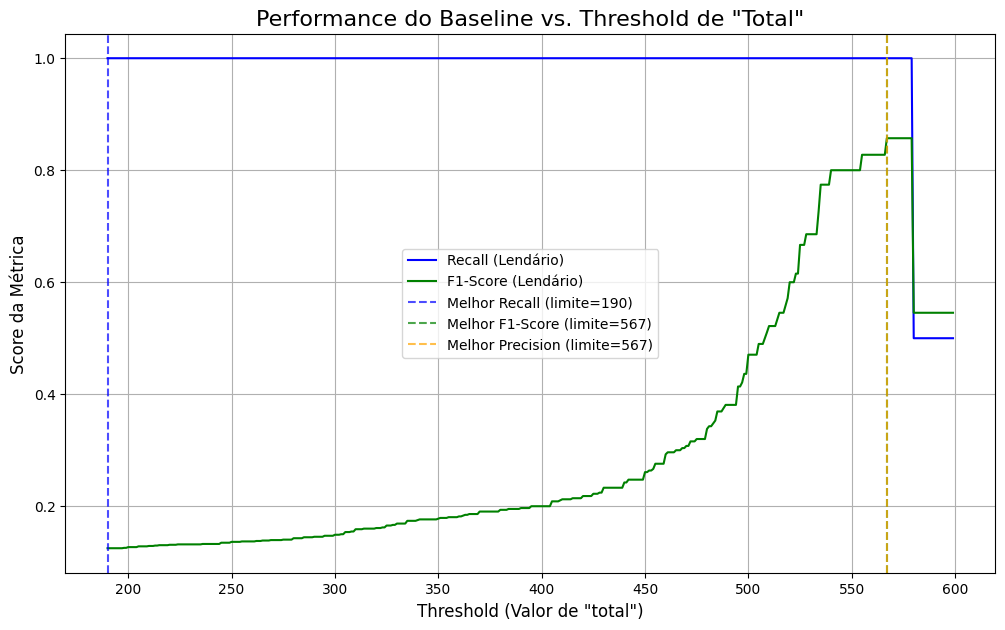

In [73]:
plt.figure(figsize=(12, 7))
plt.plot(thresholds, recall_scores, label='Recall (Lendário)', color='blue')
plt.plot(thresholds, f1_scores, label='F1-Score (Lendário)', color='green')

# Marca os pontos ótimos no gráfico
plt.axvline(best_threshold_for_recall, color='blue', linestyle='--', alpha=0.7, label=f'Melhor Recall (limite={best_threshold_for_recall})')
plt.axvline(best_threshold_for_f1, color='green', linestyle='--', alpha=0.7, label=f'Melhor F1-Score (limite={best_threshold_for_f1})')
plt.axvline(best_threshold_for_precision, color='orange', linestyle='--', alpha=0.7, label=f'Melhor Precision (limite={best_threshold_for_precision})')

plt.title('Performance do Baseline vs. Threshold de "Total"', fontsize=16)
plt.xlabel('Threshold (Valor de "total")', fontsize=12)
plt.ylabel('Score da Métrica', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

##### Achados

1. Alterar o threshold para 190 (classificaria todo os pokemons como lendários) me dá um recall de 100%, mas custa caro na precisão (quase tudo vira alarme falso).
2. Alterar o threshhold para 560 atinge uma média harmônica entre precisão e recall de 0.86. Onde o recall ainda é 1.0 e 0 precision 0.75

In [74]:
chosen_threshold = best_threshold_for_f1

y_pred_regra = (X_test_baseline > chosen_threshold)

print(classification_report(y_test_baseline, y_pred_regra, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       1.00      0.98      0.99       169
    Lendário       0.75      1.00      0.86        12

    accuracy                           0.98       181
   macro avg       0.88      0.99      0.92       181
weighted avg       0.98      0.98      0.98       181



In [75]:
df_pokemon['is_flying_or_dragon'] = (
    (df_pokemon['type_1'].isin(['Flying', 'Dragon'])) 
)

df_pokemon['is_flying_or_dragon'] = df_pokemon['is_flying_or_dragon'].astype(int)

# Razão entre ataque e defesa
df_pokemon['atk_def_ratio'] = df_pokemon['attack'] / (df_pokemon['defense'] )

# Razão entre ataque especial e defesa especial
df_pokemon['sp_atk_sp_def_ratio'] = df_pokemon['special_atk'] / (df_pokemon['special_def'] )

# Diferença entre ataque e ataque especial
df_pokemon['atk_special_diff'] = df_pokemon['attack'] - df_pokemon['special_atk']

# Diferença entre defesa e defesa especial
df_pokemon['def_special_diff'] = df_pokemon['defense'] - df_pokemon['special_def']

# Potencial ofensivo baseado em ataque, ataque especial e velocidade
df_pokemon['offensive_potential'] = (df_pokemon['attack'] + df_pokemon['special_atk']) * df_pokemon['speed']

# Bulk total baseado em hp, defesa e defesa especial
df_pokemon['bulk_total'] = df_pokemon['hp'] * (df_pokemon['defense'] + df_pokemon['special_def'])

# Quanto mais próximo de 1, maior é o dano físico em relação ao dano de ataques especiais. 
df_pokemon['physical_damage'] = df_pokemon['attack'] / (df_pokemon['attack'] + df_pokemon['special_atk'])

# Quanto mais próximo de 1, mais o pokemon tem um estilo agressivo
df_pokemon['agressive_ratio'] = (df_pokemon['attack'] + df_pokemon['special_atk']) / df_pokemon['total']

# Quanto maois próximo de 1, mais o pokemon tem um ataque forte porém é fragil.
df_pokemon['atk_def_ratio_2'] = (df_pokemon['attack'] + df_pokemon['special_atk']) / (df_pokemon['hp'] + df_pokemon['defense'] + df_pokemon['special_def'])

# Quanto mais próximo de 1, mais rápido o ataque do pokemon. 
df_pokemon['speed_efficiency'] = df_pokemon['speed'] / df_pokemon['total']

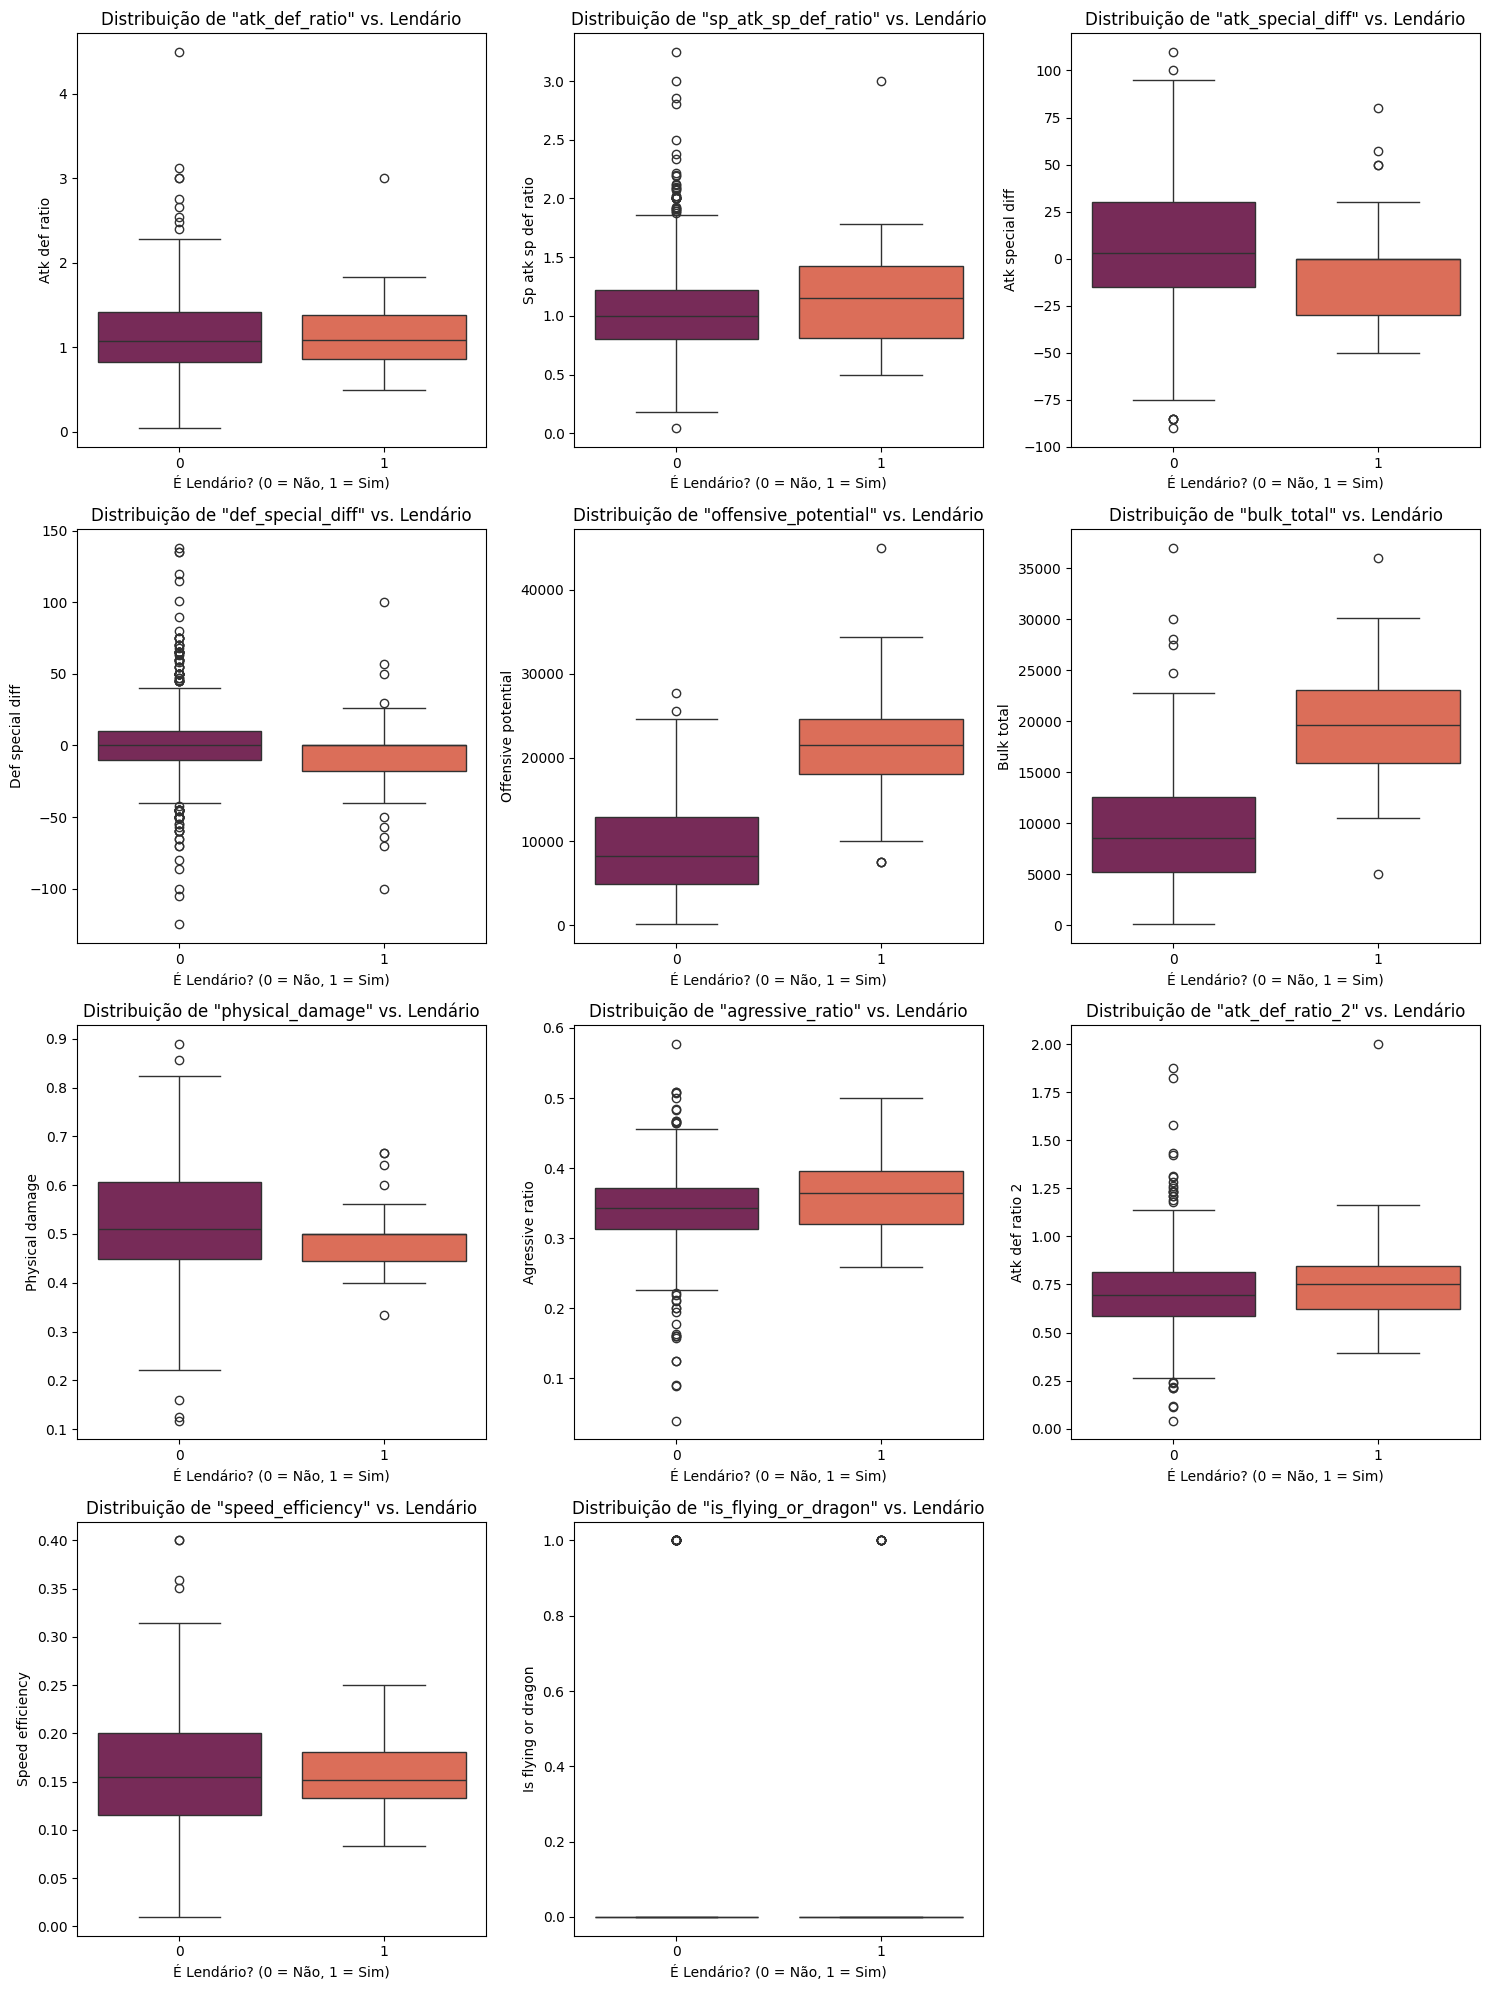

In [76]:
new_features = [
    'atk_def_ratio', 
    'sp_atk_sp_def_ratio', 
    'atk_special_diff', 
    'def_special_diff', 
    'offensive_potential',
    'bulk_total',
    'physical_damage',
    'agressive_ratio',
    'atk_def_ratio_2',
    'speed_efficiency',
    "is_flying_or_dragon"
]

# Número de colunas para os gráficos (ajuste conforme o número de features)
ncols = 3
nrows = (len(new_features) + ncols - 1) // ncols  # Calcular quantas linhas são necessárias

# Criação da figura e subgrids
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

# Ajustando a disposição para ficar mais legível
axes = axes.flatten()

# Plotando os gráficos de boxplot
for i, feature in enumerate(new_features):
    sns.boxplot(x='legendary', y=feature, data=df_pokemon, palette='rocket', ax=axes[i])
    axes[i].set_title(f'Distribuição de "{feature}" vs. Lendário', fontsize=12)
    axes[i].set_xlabel('É Lendário? (0 = Não, 1 = Sim)', fontsize=10)
    axes[i].set_ylabel(feature.replace('_', ' ').capitalize(), fontsize=10)

# Remover qualquer subplot vazio, se existir
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Ajuste dos espaços entre os gráficos
plt.tight_layout()
plt.show()

In [77]:
all_features = numerical_columns + categorical_columns + new_features

In [78]:
df_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 0 to 799
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   721 non-null    int64  
 1   name                 721 non-null    object 
 2   type_1               721 non-null    object 
 3   type_2               721 non-null    object 
 4   total                721 non-null    int64  
 5   hp                   721 non-null    int64  
 6   attack               721 non-null    int64  
 7   defense              721 non-null    int64  
 8   special_atk          721 non-null    int64  
 9   special_def          721 non-null    int64  
 10  speed                721 non-null    int64  
 11  generation           721 non-null    int64  
 12  legendary            721 non-null    int64  
 13  is_flying_or_dragon  721 non-null    int64  
 14  atk_def_ratio        721 non-null    float64
 15  sp_atk_sp_def_ratio  721 non-null    float64


In [79]:
def selecionar_features_boruta(feature_names: list, target_name: str, dataframe: pd.DataFrame, modelo: str = "lightgbm"):
    """
    Executa o algoritmo Boruta em um conjunto de features (X) para prever um alvo (y).
    Lida com pré-processamento de features categóricas internamente.
    
    Args:
        X (pd.DataFrame): DataFrame contendo as features a serem testadas.
        y (pd.Series): Série contendo a variável alvo.
        modelo (str): Modelo base para Boruta ("lightgbm", "randomforest", "decision-tree").
    
    Returns:
        list: Uma lista com os nomes das features confirmadas pelo Boruta.
    """
    # Copiando os dados
    X_copy = dataframe[feature_names].copy()
    y_copy = dataframe[target_name].copy()

    # Codifica o alvo
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_copy)
    
    # Calcula peso para desbalanceamento
    peso = np.sum(y_encoded == 0) / np.sum(y_encoded == 1)
    
    # Pré-processamento
    colunas_numericas = X_copy.select_dtypes(include=np.number).columns
    colunas_categoricas = X_copy.select_dtypes(exclude=np.number).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', colunas_numericas),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), colunas_categoricas)
        ],
        remainder='passthrough'
    )

    X_processed = preprocessor.fit_transform(X_copy)
    feature_names = preprocessor.get_feature_names_out()

    # Escolha do modelo base
    modelo = modelo.lower()
    if modelo == "lightgbm":
        estimator = LGBMClassifier(
            n_jobs=-1,
            random_state=42,
            scale_pos_weight=peso
        )
    elif modelo == "randomforest":
        estimator = RandomForestClassifier(
            n_jobs=-1,
            random_state=42,
            class_weight="balanced"
        )
    else:
        raise ValueError("Modelo inválido. Escolha entre: 'lightgbm' e 'randomforest'")

    # Executa Boruta
    boruta_selector = BorutaPy(estimator=estimator, verbose=2, random_state=42)
    boruta_selector.fit(X_processed, y_encoded)

    # Extrai features confirmadas
    confirmed_features = np.array(feature_names)[boruta_selector.support_].tolist()

    # Limpa prefixos do ColumnTransformer
    confirmed_features = [feat.replace('num__', '').replace('cat__', '') for feat in confirmed_features]

    return confirmed_features

In [40]:

features_rf = selecionar_features_boruta(all_features, target, df_pokemon, modelo="randomforest")

features_lgbm = selecionar_features_boruta(all_features, target, df_pokemon, modelo="lightgbm")


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	40
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	40
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	40
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	40
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	40
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	40
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	40
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	4
Rejected: 	40
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	3
Reject

In [41]:
print(features_rf)
print(features_lgbm)

['total', 'hp', 'attack', 'defense', 'special_atk', 'special_def', 'speed', 'sp_atk_sp_def_ratio', 'atk_special_diff', 'offensive_potential', 'bulk_total', 'physical_damage', 'agressive_ratio', 'atk_def_ratio_2', 'speed_efficiency']
['total']


In [42]:
def execute_lazy_classifier(X, y):
    """
    Executa o LazyClassifier em um conjunto de features (X) e um alvo (y).
    Lida com pré-processamento, divisão de dados e treinamento de forma automática.

    Args:
        X (pd.DataFrame): DataFrame contendo as features (pode ter tipos mistos).
        y (pd.Series): Série contendo a variável alvo.

    Returns:
        pd.DataFrame: A tabela de resultados do LazyClassifier, ordenada pela melhor performance.
    """
    X_copy = X.copy()
    y_copy = y.copy()

    # Garante que colunas booleanas sejam tratadas como números
    for col in X_copy.select_dtypes(include='bool').columns:
        X_copy[col] = X_copy[col].astype(int)

    try:
        X_train, X_test, y_train, y_test = train_test_split(X_copy, y_copy, test_size=0.2, random_state=42, stratify=y_copy)
    except ValueError:
        # Se a estratificação falhar (ex: classes com apenas 1 membro), faz uma divisão padrão
        X_train, X_test, y_train, y_test = train_test_split(X_copy, y_copy, test_size=0.2, random_state=42)
    
    colunas_numericas = X_train.select_dtypes(include=np.number).columns
    colunas_categoricas = X_train.select_dtypes(exclude=np.number).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', colunas_numericas),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), colunas_categoricas)
        ],
        remainder='passthrough'
    )
    
    # Aplica o pré-processamento
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # --- 4. Execução do LazyClassifier ---
    clf = LazyClassifier(verbose=-1, ignore_warnings=True, custom_metric=None)
    
    models = clf.fit(X_train_processed, X_test_processed, y_train, y_test)
    
    return models

In [43]:
X = df_pokemon[all_features]
y = df_pokemon[target]

In [44]:
models = execute_lazy_classifier(X, y)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 37, number of negative: 539
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1970
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064236 -> initscore=-2.678798
[LightGBM] [Info] Start training from score -2.678798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [45]:
print(models)

(                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.90               0.95     0.95      0.92   
BernoulliNB                        0.90               0.94     0.94      0.92   
BaggingClassifier                  0.97               0.93     0.93      0.97   
LinearSVC                          0.96               0.93     0.93      0.96   
XGBClassifier                      0.96               0.87     0.87      0.96   
Perceptron                         0.92               0.86     0.86      0.93   
AdaBoostClassifier                 0.96               0.82     0.82      0.96   
DecisionTreeClassifier             0.96               0.82     0.82      0.96   
LogisticRegression                 0.96               0.82     0.82      0.96   
PassiveAggressiveClassifier        0.94               0.81     0.81      0.95   
LinearDiscriminantAnalysis 

In [46]:

def preparar_dados(X, y):
    """
    Prepara os dados X e y, aplicando pré-processamento (OneHotEncoder) em X.
    """

    # Garante que colunas booleanas sejam tratadas como números
    for col in X.select_dtypes(include='bool').columns:
        X[col] = X[col].astype(int)

    colunas_numericas = X.select_dtypes(include=np.number).columns
    colunas_categoricas = X.select_dtypes(exclude=np.number).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', colunas_numericas),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), colunas_categoricas)
        ],
        remainder='passthrough'
    )

    X_processed = preprocessor.fit_transform(X)
    
    # LabelEncoder para o alvo, se for string
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    return X_processed, y

In [47]:
X_processed, y_processed = preparar_dados(X, y)

In [82]:
X_rf, y_rf = preparar_dados(df_pokemon[features_rf], df_pokemon[target])

X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf,
    test_size=0.2, 
    random_state=42,
    stratify=y_rf
)
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       0.98      0.99      0.98       136
    Lendário       0.75      0.67      0.71         9

    accuracy                           0.97       145
   macro avg       0.86      0.83      0.84       145
weighted avg       0.96      0.97      0.96       145



In [84]:
X_rf, y_rf = preparar_dados(df_pokemon[numerical_columns], df_pokemon[target])

X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf,
    test_size=0.2, 
    random_state=42,
    stratify=y_rf
)
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       0.98      0.97      0.97       136
    Lendário       0.60      0.67      0.63         9

    accuracy                           0.95       145
   macro avg       0.79      0.82      0.80       145
weighted avg       0.95      0.95      0.95       145



In [85]:
X_rf, y_rf = preparar_dados(df_pokemon[features_lgbm], df_pokemon[target])

X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf,
    test_size=0.2, 
    random_state=42,
    stratify=y_rf
)
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       1.00      0.97      0.99       136
    Lendário       0.69      1.00      0.82         9

    accuracy                           0.97       145
   macro avg       0.85      0.99      0.90       145
weighted avg       0.98      0.97      0.97       145



In [42]:
X_lgbm, y_lgbm = preparar_dados(df_pokemon[numerical_columns], df_pokemon[target])

X_train, X_test, y_train, y_test = train_test_split(
    X_lgbm, y_lgbm,
    test_size=0.2, 
    random_state=42,
    stratify=y_lgbm
)
model = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1, verbose=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       1.00      0.97      0.99       136
    Lendário       0.69      1.00      0.82         9

    accuracy                           0.97       145
   macro avg       0.85      0.99      0.90       145
weighted avg       0.98      0.97      0.97       145



In [43]:
X_lgbm, y_lgbm = preparar_dados(df_pokemon[numerical_columns + categorical_columns], df_pokemon[target])

X_train, X_test, y_train, y_test = train_test_split(
    X_lgbm, y_lgbm,
    test_size=0.2, 
    random_state=42,
    stratify=y_lgbm
)
model = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1, verbose=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       0.99      0.97      0.98       136
    Lendário       0.64      0.78      0.70         9

    accuracy                           0.96       145
   macro avg       0.81      0.87      0.84       145
weighted avg       0.96      0.96      0.96       145



In [44]:
X_lgbm, y_lgbm = preparar_dados(df_pokemon[numerical_columns + categorical_columns + new_features], df_pokemon[target])

X_train, X_test, y_train, y_test = train_test_split(
    X_lgbm, y_lgbm,
    test_size=0.2, 
    random_state=42,
    stratify=y_lgbm
)
model = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1, verbose=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       0.98      0.97      0.97       136
    Lendário       0.60      0.67      0.63         9

    accuracy                           0.95       145
   macro avg       0.79      0.82      0.80       145
weighted avg       0.95      0.95      0.95       145



In [45]:
X_lgbm, y_lgbm = preparar_dados(df_pokemon[features_lgbm], df_pokemon[target])

X_train, X_test, y_train, y_test = train_test_split(
    X_lgbm, y_lgbm,
    test_size=0.2, 
    random_state=42,
    stratify=y_lgbm
)
model = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1, verbose=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       1.00      0.97      0.99       136
    Lendário       0.69      1.00      0.82         9

    accuracy                           0.97       145
   macro avg       0.85      0.99      0.90       145
weighted avg       0.98      0.97      0.97       145



In [46]:
X_lgbm, y_lgbm = preparar_dados(df_pokemon[features_lgbm], df_pokemon[target])

X_train, X_test, y_train, y_test = train_test_split(
    X_lgbm, y_lgbm,
    test_size=0.2, 
    random_state=42,
    stratify=y_lgbm
)

contagem_comuns = (y_train == 0).sum()
contagem_lendarios = (y_train == 1).sum()
if contagem_lendarios > 0:
    peso = contagem_comuns / contagem_lendarios
else:
    peso = 1


model = LGBMClassifier(random_state=42, scale_pos_weight=peso, n_jobs=-1, verbose=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       1.00      0.97      0.99       136
    Lendário       0.69      1.00      0.82         9

    accuracy                           0.97       145
   macro avg       0.85      0.99      0.90       145
weighted avg       0.98      0.97      0.97       145



In [47]:
X_rf, y_rf = preparar_dados(df_pokemon[features_lgbm], df_pokemon[target])

X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf,
    test_size=0.2, 
    random_state=42,
    stratify=y_rf
)
model = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1, verbose=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       1.00      0.97      0.99       136
    Lendário       0.69      1.00      0.82         9

    accuracy                           0.97       145
   macro avg       0.85      0.99      0.90       145
weighted avg       0.98      0.97      0.97       145



In [48]:
X_rf, y_rf = preparar_dados(df_pokemon[["total"]], df_pokemon[target])

X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf,
    test_size=0.2, 
    random_state=42,
    stratify=y_rf
)
model = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1, verbose=-1,  monotone_constraints=[1])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Comum', 'Lendário']))

              precision    recall  f1-score   support

       Comum       1.00      0.97      0.99       136
    Lendário       0.69      1.00      0.82         9

    accuracy                           0.97       145
   macro avg       0.85      0.99      0.90       145
weighted avg       0.98      0.97      0.97       145



In [49]:
df_resultados = df_pokemon.loc[y_test.index].copy()
df_resultados['previsao'] = y_pred
df_resultados['acertou'] = (df_resultados['legendary'] == df_resultados['previsao'])

falsos_positivos = df_resultados[(df_resultados['legendary'] == 0) & (df_resultados['previsao'] == 1)]

display(falsos_positivos.sort_values(by='total', ascending=False))



id       name   type_1   type_2  total   hp  attack  defense  \
412  376  Metagross    Steel  Psychic    600   80     135      130   
546  488  Cresselia  Psychic     None    600  120      70      120   
271  251     Celebi  Psychic    Grass    600  100     100      100   
267  248  Tyranitar     Rock     Dark    600  100     134      110   

     special_atk  special_def  ...  atk_special_diff  def_special_diff  \
412           95           90  ...                40                40   
546           75          130  ...                -5               -10   
271          100          100  ...                 0                 0   
267           95          100  ...                39                10   

     offensive_potential  bulk_total  physical_damage  agressive_ratio  \
412                16100       17600             0.59             0.38   
546                12325       30000             0.48             0.24   
271                20000       20000             0.50             0.33   
267                13969       21000             0.59             0.38   

     atk_def_ratio_2  speed_efficiency  previsao  acertou  
412             0.77              0.12         1    False  
546             0.39              0.14         1    False  
271             0.67              0.17         1    False  
267             0.74              0.10         1    False  

[4 rows x 26 columns]